#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [1]:
import cv2
## import numpy
## import matplotlib pyplot
## import KMeans cluster from sklearn
## import distance from scipy.spatial
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
## Reading the image plaksha_Faculty.jpg
faculty = cv2.imread('Plaksha_Faculty.jpg')
shashi = cv2.imread('Dr_Shashi_Tharoor.jpg')
  
## Convert the image to grayscale

  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(__________________________________)
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = ____________ ## The text you want to write
font = _________________________________  ## Font type
font_scale = _________  ## Font scale factor
font_color = _____________  ## Text color in BGR format (here, it's red)
font_thickness = ________  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(____________________________________________________________________)
    
## Display the image and window title should be "Total number of face detected are #"  
cv2.imshow(__________________________________________________________)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\Makerspace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


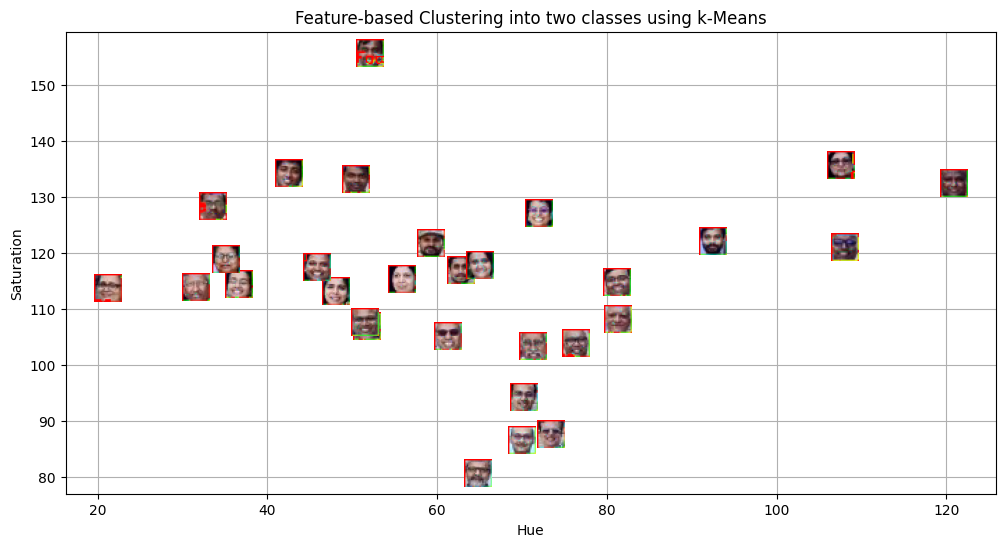

In [121]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(_________________________) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = ___________________________________________________
#centroids = kmeans.cluster_centers_
#labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

## Put x label
## Put y label
## Put title
## Put grid
## show the plot

In [ ]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(______________________________________________________________________________)


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(_______________________________________________________________________________)

# Calculate and plot centroids
centroid_0 = _________________________________________
centroid_1 = _________________________________________

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(____________________________________________________________________________________)
plt.scatter(____________________________________________________________________________________)

## Put x label
## Put y label
## Put title
## Add a legend
## Add grid
## Show the plot


In [ ]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = _____________________________________________
# Detect face  in the template image after converting it to gray and store it in template_faces
template_faces = ___________________________________________________________________________________________
# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.imshow(_____________________________________________________)
cv2.waitKey(0)
cv2.destroyAllWindows()      

In [ ]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = __________________________________________________

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = ____________________________________________________
template_saturation = _________________________________________________

# Predict the cluster label for the template image and store it in template_label
template_label = _________________________________________________________

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
## Put y label
## Put title
## Add grid
## show plot

In [ ]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(_______________________________________________________________________________)

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(________________________________________________________________________________)

# Calculate and plot centroids for both the clusters
centroid_0 = __________________________________________________
centroid_1 = __________________________________________________
plt.scatter(____________________________________________________________ _________________) ## plot for centroid 0
plt.scatter(_____________________________________________________________________________)  ## plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )

## Put x label
## Put y label
## Put title
## Add a legend
## Add grid
## show the plot
                                            ## End of the lab 5 ##

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 

#### 2. What are some real-world applications of distance-based classification algorithms? 

#### 3. Explain various distance metrics. 

#### 4. What is the role of cross validation in model performance? 

#### 5. Explain variance and bias in terms of KNN? 